# Determine the Optimal Learning Rate for NAdam in CIFAR10 Classification

The goal of this notebook is to find an approach that determines the optimal learning rate (LR) for the NAdam optimizer. We used a 4 hidden layer based Convolutional Neural Network (CNN) followed by 2 dense layers and a final layer to classify CIFAR10 dataset. Note that the optimal LR is problem dependent. So the results obtained from the experiments of this notebook may not generalize across other datasets. Our goal is to find the best approach for obtaining an optimal LR for adaptive optimizers like NAdam.

We used two approaches to determine the optimal LR for NAdam.
- Approach 1: Train the CNN **partially** for a few epochs by increasing LR within a range and use the LR that gives minimum loss as the optimal LR.
- Approach 2: Train the CNN **fully** for a large and fixed number of epochs (100 epochs) multiple times by varying the LR from a very small value to a large value. The optimal LR is then selected from the best performing model.



## Experiments

We perform the following experiments to investigate the above two approaches. Experiment 1 implements approach 1 and the rest of the experiments implement approach 2. 


- Experiment 1: NAdam (Optimal lr)
- Experiment 2: NAdam (lr = 0.0001)
- Experiment 3: NAdam (lr = 0.0002)
- Experiment 4: NAdam (lr = 0.0003)
- Experiment 5: NAdam (lr = 0.0004)
- Experiment 6: NAdam (lr = 0.0005)
- Experiment 7: NAdam (lr = 0.0006)
- Experiment 8: NAdam (lr = 0.0007)
- Experiment 9: NAdam (lr = 0.0008)
- Experiment 10: NAdam (lr = 0.0009)
- Experiment 11: NAdam (lr = 0.001)
- Experiment 12: NAdam (lr = 0.005)
- Experiment 13: NAdam (lr = 0.007)
- Experiment 14: NAdam (lr = 0.03)
- Experiment 15: NAdam (lr = 0.05)
- Experiment 16: NAdam (lr = 0.07)
- Experiment 17: NAdam (lr = 0.09)
- Experiment 18: NAdam (lr = 0.1)


We keep the other hyperparameters of NAdam to their default values. We use Orthogonal initializer as the weight initializer and ELU as the activation function. In addition to this, we use increasing Dropout for the 4 hidden layers with dropout rate 0.2, 0.3, 0.4, and 0.5, respectively.


        These experiments are conducted on a GPU from Google Colaboratory.


In [1]:
import warnings
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

In [2]:
# Check whether a GPU is added
tf.test.gpu_device_name()

'/device:GPU:0'

## Load and Scale the Dataset

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train_full = X_train_full.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train_full[5000:]/255.0
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]/255.0
y_valid = y_train_full[:5000]

X_test = X_test/255.0

print("\nShape of Training Samples: ", X_train.shape)
print("Shape of Training Labels: ", y_train.shape)

print("\nShape of Validation Samples: ", X_valid.shape)
print("Shape of Validation Labels: ", y_valid.shape)

print("\nShape of Testing Samples: ", X_test.shape)
print("Shape of Testing Labels: ", y_test.shape)

print("\nData type: ", X_train.dtype)
print("Label type: ", y_train.dtype)


Shape of Training Samples:  (45000, 32, 32, 3)
Shape of Training Labels:  (45000, 1)

Shape of Validation Samples:  (5000, 32, 32, 3)
Shape of Validation Labels:  (5000, 1)

Shape of Testing Samples:  (10000, 32, 32, 3)
Shape of Testing Labels:  (10000, 1)

Data type:  float32
Label type:  uint8


## Functions for Various Learning Curves & Converting Training Time

In [4]:
'''
Function For Generating Learning Curves (Accuracy & Loss)
'''
def plot_learning_curves(history, numOfEpochs, title):
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 
    
    
# Plot learning rate & momentum
def plot_learning_rate(loss_history_lschedule, numOfEpochs, title, momentumPlot=False):
    plt.figure(figsize=(10,6))
    plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.lr,label='learning rate')
    plt.xlabel("Epoch")
    plt.xlim([1,numOfEpochs+1])
    plt.ylabel("Learning rate")
    
    if(momentumPlot==True):
        plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.mom,'r-', label='momentum')
        plt.ylabel("Learning rate & Momentum")
    
    
    plt.legend(loc=0)
    plt.grid(True)
    plt.title(title)
    plt.show()

    
'''
Function to Convert Seconds into Hours, Minutes and Seconds
'''
def convertTime(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    if(hour == 0):
        return "{0:2.0f} min {1:2.0f} s".format(minutes, seconds) 
    
    elif(hour == 0 and minutes == 0):
        return "{1:2.0f} s".format(seconds) 
    
    else:
        return "{0:2.0f} h {1:2.0f} min {2:2.0f} s".format(hour, minutes, seconds) 

## Class to store the Changing Loss and Learning Rates

In [5]:
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

## Heuristic to Find Optimal Constant Learning Rate

To find an optimal constant learing rate we train the network for one epoch and grow the learning rate at each iteration. Then, by observing the change in loss at each iteration we find the optimal learning rate.


To increase the learning rate by a constant factor we define the following class.

In [6]:
'''
A class to increase the learning rate by a "factor" at each iteration.
It stores the changing learning rate and loss at each iteration.
'''

K = keras.backend

class IncreaseLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
   

## Experiment 1: Finding an Optimal Constant Learning Rate for NAdam

First we create the CNN.

Then, we create an IncreaseLearningRate object (class defined above). We use it to increase the learning rate by x% at each iteration. We pass this object as a callback to the fit() method of the model.

We start with a small learning rate of 0.0001, and grow it by 0.1% at each iteration. Then, using a loss vs. learning rate plot we find the optimal constant learning rate.

In [7]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.0001)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])




'''
Create an IncreaseLearningRate object.
It increases the learning rate by some factor (determined by 'computeFactorForIncreasingLearningRate' function)
We start with a small learning rate, and grow it by the factor at each iteration up to a large learning rate.
'''
size_mini_batch = 64
no_of_epochs = 1

increase_lr_cb = IncreaseLearningRate(factor=1.001)

'''
Train the model
'''
model.fit(X_train, y_train, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[increase_lr_cb])

704/704 [==============================] - 7s 10ms/step - loss: 1.7813 - accuracy: 0.3496 - val_loss: 1.5654 - val_accuracy: 0.4410
CPU times: user 9.88 s, sys: 1.82 s, total: 11.7 s
Wall time: 11.4 s


## Plot the Loss as a Function of the Learning Rate

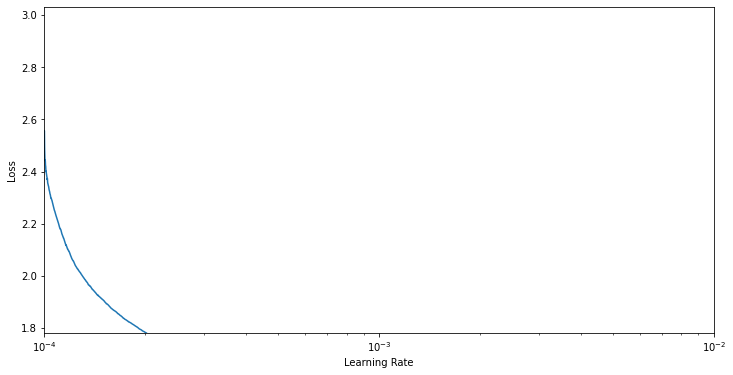

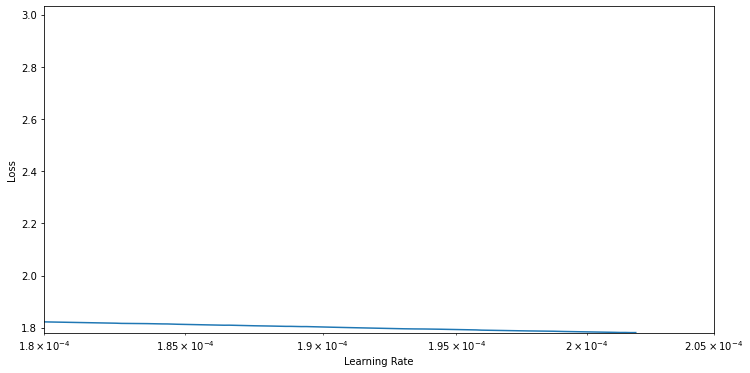

In [8]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 0.01)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


'''
For clarity we zoom into a chosen section of the x-axis
'''
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.00018, 0.000205)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Optimal Learning Rate for NAdam
We see that the loss starts increasing beyond the learning rate 0.0002. Thus, we use 0.0002 as our optimal learning rate.


## Experiment 1: NAdam with Optimal Learning Rate

In [9]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.0002)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam_opt"
model_name_format = "Nadam_opt.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam_opt = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam_opt_sec = t1-t0
duration_Nadam_opt = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam_opt)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 7s 10ms/step - loss: 1.6945 - accuracy: 0.3837 - val_loss: 1.4506 - val_accuracy: 0.4832
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 1.3344 - accuracy: 0.5247 - val_loss: 1.1642 - val_accuracy: 0.5822
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 1.1732 - accuracy: 0.5882 - val_loss: 0.9877 - val_accuracy: 0.6532
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 1.0793 - accuracy: 0.6210 - val_loss: 1.0628 - val_accuracy: 0.6218
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 1.0150 - accuracy: 0.6454 - val_loss: 0.9080 - val_accuracy: 0.6872
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 0.9636 - accuracy: 0.6635 - val_loss: 0.8622 - val_accuracy: 0.6988
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 0.9164 - accuracy: 0.6822 - val_loss: 1.4731 - val_accuracy:

Epochs:  100

Nadam_opt Test Accuracy: 0.845
Nadam_opt Test Loss: 0.568

Test Confusion Matrix:
[[864  11  21  14   7   2   4   8  35  34]
 [  8 892   1   1   0   5   2   0  10  81]
 [ 48   0 777  39  48  38  23  20   3   4]
 [ 13   1  42 689  43 129  42  17   5  19]
 [  9   1  41  27 842  26  16  31   5   2]
 [  6   1  28 109  26 789  12  19   4   6]
 [  4   2  36  36  19  12 885   2   2   2]
 [  7   1  17  20  28  38   5 881   0   3]
 [ 43  12   5   8   3   2   3   2 894  28]
 [ 13  21   3   2   1   0   1   7  14 938]]


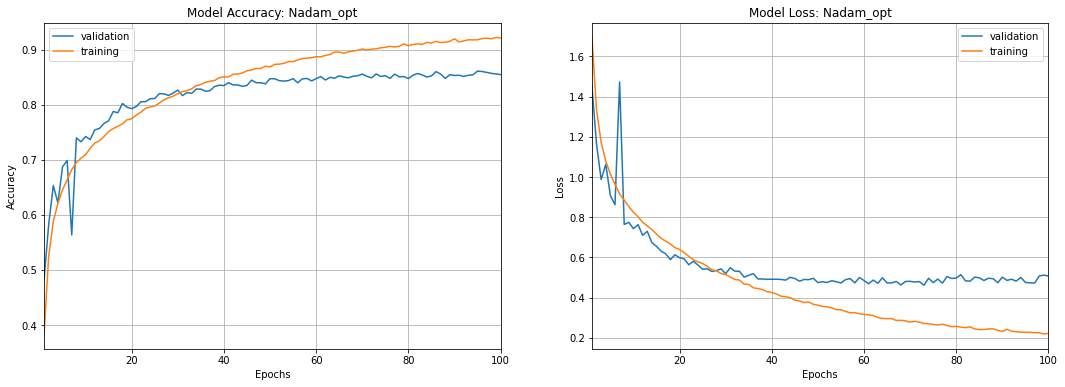

In [10]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam_opt.h5")

numOfEpochs_Nadam_opt = len(history_Nadam_opt.history['loss'])
print("Epochs: ", numOfEpochs_Nadam_opt)

test_loss_Nadam_opt, test_accuracy_Nadam_opt = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam_opt))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam_opt))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam_opt, numOfEpochs_Nadam_opt, 
                     model_name)

## Experiment 2: NAdam (lr = 0.0001)

In [11]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.0001)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam0001"
model_name_format = "Nadam0001.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam0001 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam0001_sec = t1-t0
duration_Nadam0001 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam0001)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 7s 10ms/step - loss: 1.8025 - accuracy: 0.3428 - val_loss: 1.6294 - val_accuracy: 0.4114
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 1.4911 - accuracy: 0.4614 - val_loss: 1.4604 - val_accuracy: 0.4732
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 1.3366 - accuracy: 0.5257 - val_loss: 1.1427 - val_accuracy: 0.6006
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 1.2243 - accuracy: 0.5668 - val_loss: 1.1612 - val_accuracy: 0.5722
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 1.1510 - accuracy: 0.5944 - val_loss: 0.9961 - val_accuracy: 0.6532
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 1.0991 - accuracy: 0.6146 - val_loss: 1.0116 - val_accuracy: 0.6486
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 1.0520 - accuracy: 0.6324 - val_loss: 1.6062 - val_accuracy:

Epochs:  100

Nadam0001 Test Accuracy: 0.836
Nadam0001 Test Loss: 0.553

Test Confusion Matrix:
[[874  10  16  14   8   4   5   9  34  26]
 [ 10 902   1   1   2   3   4   0  12  65]
 [ 59   2 744  33  53  47  38  17   2   5]
 [ 15   6  33 672  44 131  48  27  12  12]
 [ 12   2  47  32 819  23  33  28   4   0]
 [  8   2  24 124  33 769  15  21   2   2]
 [  4   4  27  39  15  15 885   6   1   4]
 [  7   1   8  16  26  46   3 887   1   5]
 [ 49  12   3   8   2   2   4   1 897  22]
 [ 23  33   2   3   2   3   3   5  14 912]]


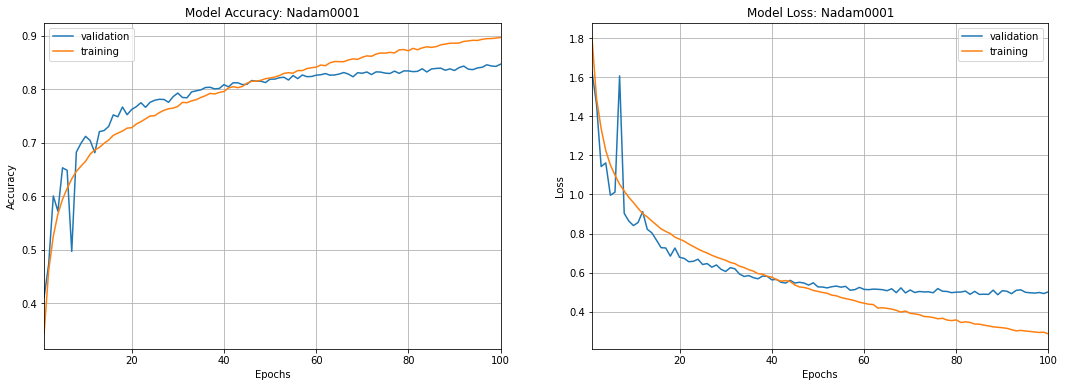

In [12]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam0001.h5")

numOfEpochs_Nadam0001 = len(history_Nadam0001.history['loss'])
print("Epochs: ", numOfEpochs_Nadam0001)

test_loss_Nadam0001, test_accuracy_Nadam0001 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam0001))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam0001))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam0001, numOfEpochs_Nadam0001, 
                     model_name)

## Experiment 3: NAdam (lr = 0.0002)

In [13]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.0002)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam0002"
model_name_format = "Nadam0002.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam0002 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam0002_sec = t1-t0
duration_Nadam0002 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam0002)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 7s 10ms/step - loss: 1.6947 - accuracy: 0.3831 - val_loss: 1.4410 - val_accuracy: 0.4882
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 1.3335 - accuracy: 0.5259 - val_loss: 1.1749 - val_accuracy: 0.5810
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 1.1725 - accuracy: 0.5886 - val_loss: 0.9918 - val_accuracy: 0.6510
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 1.0790 - accuracy: 0.6221 - val_loss: 1.0629 - val_accuracy: 0.6236
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 1.0138 - accuracy: 0.6457 - val_loss: 0.9186 - val_accuracy: 0.6876
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 0.9635 - accuracy: 0.6661 - val_loss: 0.8718 - val_accuracy: 0.6972
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 0.9156 - accuracy: 0.6829 - val_loss: 1.4787 - val_accuracy:

Epochs:  100

Nadam0002 Test Accuracy: 0.845
Nadam0002 Test Loss: 0.550

Test Confusion Matrix:
[[866   9  23  15  12   4   2   9  30  30]
 [  9 897   2   3   1   1   3   1  14  69]
 [ 31   2 767  42  53  44  38  15   4   4]
 [ 16   1  33 684  48 126  51  20   7  14]
 [ 10   1  36  36 844  19  26  23   4   1]
 [  4   1  30 116  35 774  14  22   2   2]
 [  5   0  20  33  19   9 907   4   1   2]
 [  8   2  16  21  30  33   3 882   0   5]
 [ 42  13   3   8   3   2   5   1 901  22]
 [ 12  27   3   6   1   0   1   7  16 927]]


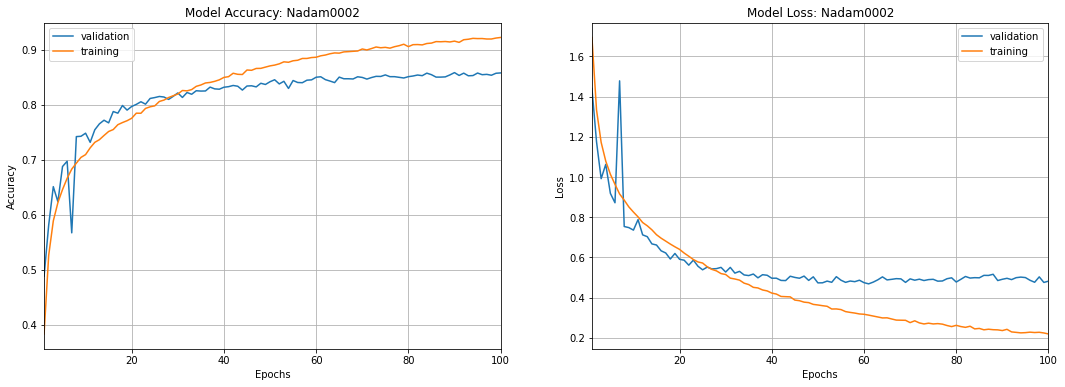

In [14]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam0002.h5")

numOfEpochs_Nadam0002 = len(history_Nadam0002.history['loss'])
print("Epochs: ", numOfEpochs_Nadam0002)

test_loss_Nadam0002, test_accuracy_Nadam0002 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam0002))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam0002))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam0002, numOfEpochs_Nadam0002, 
                     model_name)

## Experiment 4: NAdam (lr = 0.0003)

In [15]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.0003)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam0003"
model_name_format = "Nadam0003.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam0003 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam0003_sec = t1-t0
duration_Nadam0003 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam0003)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 8s 11ms/step - loss: 1.6351 - accuracy: 0.4078 - val_loss: 1.3673 - val_accuracy: 0.5248
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 1.2581 - accuracy: 0.5557 - val_loss: 1.1846 - val_accuracy: 0.5812
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 1.1100 - accuracy: 0.6117 - val_loss: 0.9904 - val_accuracy: 0.6506
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 1.0202 - accuracy: 0.6453 - val_loss: 0.9203 - val_accuracy: 0.6790
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 0.9563 - accuracy: 0.6661 - val_loss: 0.9145 - val_accuracy: 0.6950
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 0.9065 - accuracy: 0.6852 - val_loss: 0.8264 - val_accuracy: 0.7142
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 0.8589 - accuracy: 0.7024 - val_loss: 1.1076 - val_accuracy:

Epochs:  100

Nadam0003 Test Accuracy: 0.846
Nadam0003 Test Loss: 0.593

Test Confusion Matrix:
[[852   8  26  16  10   3   6   7  48  24]
 [  9 918   1   3   0   2   2   2   8  55]
 [ 50   3 752  30  44  55  40  14   6   6]
 [ 13   4  35 667  42 159  40  18  10  12]
 [  7   2  30  24 839  35  22  33   7   1]
 [  9   1  20  80  19 826  12  29   1   3]
 [  5   4  25  32  17  10 895   8   1   3]
 [  9   1  14  13  26  47   4 881   2   3]
 [ 28  12   1   5   1   3   3   4 924  19]
 [ 24  38   3   3   0   2   2   6  12 910]]


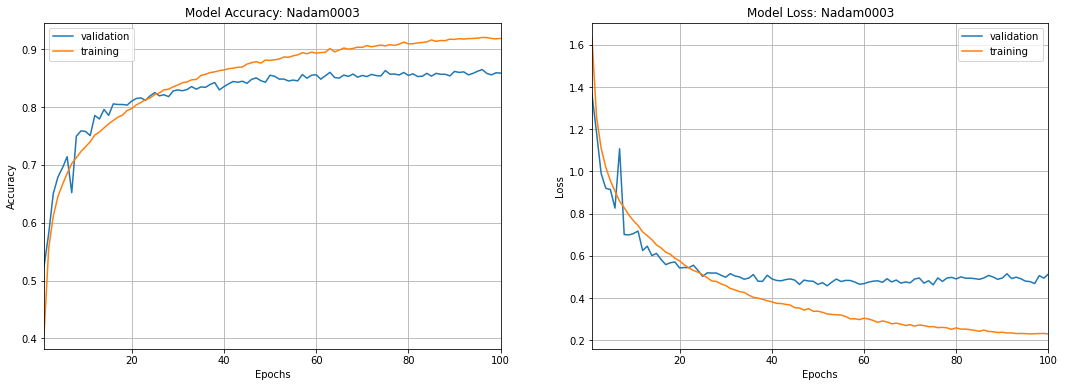

In [16]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam0003.h5")

numOfEpochs_Nadam0003 = len(history_Nadam0003.history['loss'])
print("Epochs: ", numOfEpochs_Nadam0003)

test_loss_Nadam0003, test_accuracy_Nadam0003 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam0003))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam0003))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam0003, numOfEpochs_Nadam0003, 
                     model_name)

## Experiment 5: NAdam (lr = 0.0004)

In [17]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.0004)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam0003"
model_name_format = "Nadam0003.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam0004 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam0004_sec = t1-t0
duration_Nadam0004 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam0004)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 7s 11ms/step - loss: 1.5977 - accuracy: 0.4235 - val_loss: 1.2708 - val_accuracy: 0.5658
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 1.2238 - accuracy: 0.5703 - val_loss: 1.0641 - val_accuracy: 0.6288
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 1.0738 - accuracy: 0.6244 - val_loss: 1.0416 - val_accuracy: 0.6486
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 0.9876 - accuracy: 0.6565 - val_loss: 0.8764 - val_accuracy: 0.6940
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 0.9255 - accuracy: 0.6768 - val_loss: 0.8828 - val_accuracy: 0.7042
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 0.8768 - accuracy: 0.6950 - val_loss: 0.7849 - val_accuracy: 0.7286
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 0.8306 - accuracy: 0.7116 - val_loss: 1.0249 - val_accuracy:

Epochs:  100

Nadam0003 Test Accuracy: 0.847
Nadam0003 Test Loss: 0.542

Test Confusion Matrix:
[[851  11  25  10  12   6   8  13  37  27]
 [  7 929   3   4   2   2   2   0  12  39]
 [ 43   1 762  38  51  36  38  24   5   2]
 [ 16   2  39 677  38 141  46  29   4   8]
 [ 13   2  35  34 832  22  16  42   4   0]
 [  8   1  23  88  29 800  19  30   0   2]
 [  2   2  19  31  16  12 913   3   1   1]
 [  8   1  13  18  19  28   4 906   2   1]
 [ 37  18   4   9   3   4   3   5 905  12]
 [ 17  53   4   6   0   0   2   8  18 892]]


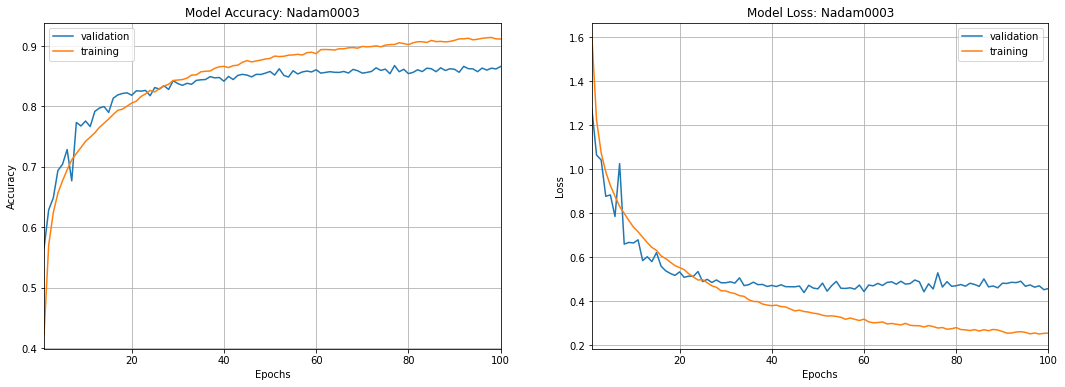

In [18]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam0004.h5")

numOfEpochs_Nadam0004 = len(history_Nadam0004.history['loss'])
print("Epochs: ", numOfEpochs_Nadam0004)

test_loss_Nadam0004, test_accuracy_Nadam0004 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam0004))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam0004))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam0004, numOfEpochs_Nadam0004, 
                     model_name)

## Experiment 6: NAdam (lr = 0.0005)

In [19]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.0005)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam0005"
model_name_format = "Nadam0005.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam0005 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam0005_sec = t1-t0
duration_Nadam0005 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam0005)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 7s 10ms/step - loss: 1.5773 - accuracy: 0.4334 - val_loss: 1.3781 - val_accuracy: 0.5238
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 1.1955 - accuracy: 0.5836 - val_loss: 1.2696 - val_accuracy: 0.5774
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 1.0542 - accuracy: 0.6281 - val_loss: 0.9805 - val_accuracy: 0.6672
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 0.9685 - accuracy: 0.6629 - val_loss: 0.8238 - val_accuracy: 0.7110
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 0.9053 - accuracy: 0.6844 - val_loss: 0.8761 - val_accuracy: 0.7070
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 0.8541 - accuracy: 0.7023 - val_loss: 0.7468 - val_accuracy: 0.7390
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 0.8116 - accuracy: 0.7181 - val_loss: 1.0117 - val_accuracy:

Epochs:  100

Nadam0005 Test Accuracy: 0.846
Nadam0005 Test Loss: 0.552

Test Confusion Matrix:
[[851  10  39   4   7   0   4   7  50  28]
 [  9 925   0   3   2   1   1   0  10  49]
 [ 36   1 815  27  50  17  26  15   8   5]
 [ 26   3  58 699  62  67  40  22  10  13]
 [  4   1  43  20 876   6  12  32   4   2]
 [ 12   2  64 150  47 669  15  33   4   4]
 [  5   4  39  32  22   3 886   4   4   1]
 [ 13   2  19  23  36  14   3 882   2   6]
 [ 23  15   8   3   3   1   2   1 933  11]
 [ 17  34   2   2   1   0   0   5  14 925]]


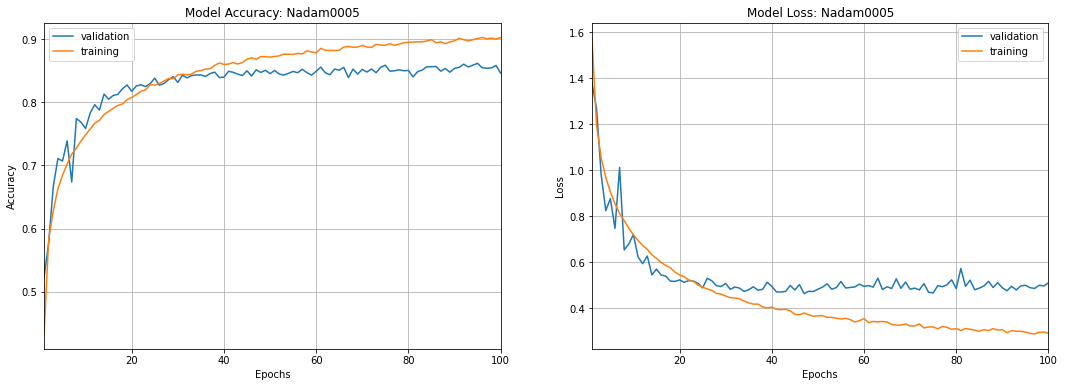

In [20]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam0005.h5")

numOfEpochs_Nadam0005 = len(history_Nadam0005.history['loss'])
print("Epochs: ", numOfEpochs_Nadam0005)

test_loss_Nadam0005, test_accuracy_Nadam0005 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam0005))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam0005))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam0005, numOfEpochs_Nadam0005, 
                     model_name)

## Experiment 7: NAdam (lr = 0.0006)

In [21]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.0006)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam0006"
model_name_format = "Nadam0006.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam0006 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam0006_sec = t1-t0
duration_Nadam0006 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam0006)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 7s 11ms/step - loss: 1.5609 - accuracy: 0.4377 - val_loss: 1.2139 - val_accuracy: 0.5836
Epoch 2/100
704/704 [==============================] - 8s 11ms/step - loss: 1.1764 - accuracy: 0.5882 - val_loss: 1.0579 - val_accuracy: 0.6274
Epoch 3/100
704/704 [==============================] - 8s 11ms/step - loss: 1.0409 - accuracy: 0.6353 - val_loss: 0.9087 - val_accuracy: 0.6844
Epoch 4/100
704/704 [==============================] - 8s 11ms/step - loss: 0.9549 - accuracy: 0.6658 - val_loss: 0.8591 - val_accuracy: 0.6968
Epoch 5/100
704/704 [==============================] - 8s 11ms/step - loss: 0.8903 - accuracy: 0.6900 - val_loss: 0.8289 - val_accuracy: 0.7212
Epoch 6/100
704/704 [==============================] - 7s 11ms/step - loss: 0.8464 - accuracy: 0.7045 - val_loss: 0.7203 - val_accuracy: 0.7542
Epoch 7/100
704/704 [==============================] - 7s 11ms/step - loss: 0.8025 - accuracy: 0.7197 - val_loss: 1.0365 - val_accuracy:

Epochs:  100

Nadam0006 Test Accuracy: 0.848
Nadam0006 Test Loss: 0.539

Test Confusion Matrix:
[[835   8  46   6  11   0   6   9  58  21]
 [  9 921   1   3   2   1   3   0  13  47]
 [ 36   2 787  24  52  36  32  16  11   4]
 [ 18   3  46 685  51  97  54  18  16  12]
 [  5   1  25  18 887  14  17  25   8   0]
 [ 10   1  34 113  37 746   8  35   9   7]
 [  6   4  27  27  27   8 891   4   2   4]
 [ 10   2  22  21  32  26   4 881   1   1]
 [ 32  11   5   4   2   2   1   3 927  13]
 [ 14  39   3   1   2   0   0   7  16 918]]


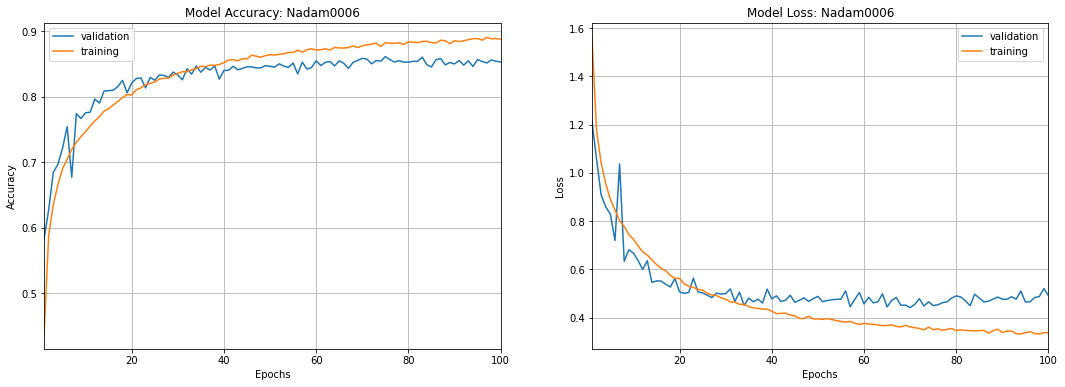

In [22]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam0006.h5")

numOfEpochs_Nadam0006 = len(history_Nadam0006.history['loss'])
print("Epochs: ", numOfEpochs_Nadam0006)

test_loss_Nadam0006, test_accuracy_Nadam0006 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam0006))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam0006))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam0006, numOfEpochs_Nadam0006, 
                     model_name)

## Experiment 8: NAdam (lr = 0.0007)

In [23]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.0007)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam0007"
model_name_format = "Nadam0007.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam0007 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam0007_sec = t1-t0
duration_Nadam0007 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam0007)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 7s 10ms/step - loss: 1.5521 - accuracy: 0.4452 - val_loss: 1.3631 - val_accuracy: 0.5410
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 1.1678 - accuracy: 0.5947 - val_loss: 1.0229 - val_accuracy: 0.6420
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 1.0285 - accuracy: 0.6394 - val_loss: 0.9297 - val_accuracy: 0.6738
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 0.9541 - accuracy: 0.6664 - val_loss: 0.8510 - val_accuracy: 0.7038
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 0.8906 - accuracy: 0.6901 - val_loss: 0.8457 - val_accuracy: 0.7132
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 0.8433 - accuracy: 0.7064 - val_loss: 0.6990 - val_accuracy: 0.7604
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 0.8050 - accuracy: 0.7196 - val_loss: 1.0292 - val_accuracy:

Epochs:  100

Nadam0007 Test Accuracy: 0.840
Nadam0007 Test Loss: 0.569

Test Confusion Matrix:
[[876   7  18  18   9   1   3  10  43  15]
 [ 15 895   2   3   1   0   2   0  24  58]
 [ 55   0 741  63  42  36  36  16   8   3]
 [ 19   2  30 761  27  77  45  16  16   7]
 [ 12   1  34  51 818  22  17  35  10   0]
 [ 11   0  25 177  21 716  17  26   6   1]
 [  8   3  26  36  25  14 879   4   3   2]
 [  9   1  22  39  23  24   3 873   4   2]
 [ 32   2   1   7   1   2   2   1 945   7]
 [ 23  33   3   7   0   4   2   8  24 896]]


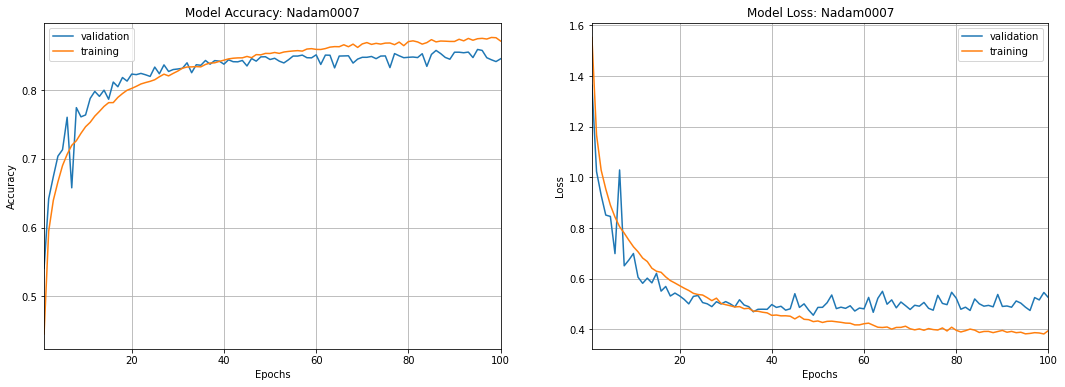

In [24]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam0007.h5")

numOfEpochs_Nadam0007 = len(history_Nadam0007.history['loss'])
print("Epochs: ", numOfEpochs_Nadam0007)

test_loss_Nadam0007, test_accuracy_Nadam0007 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam0007))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam0007))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam0007, numOfEpochs_Nadam0007, 
                     model_name)

## Experiment 9: NAdam (lr = 0.0008)

In [25]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.0008)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam0008"
model_name_format = "Nadam0008.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam0008 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam0008_sec = t1-t0
duration_Nadam0008 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam0008)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 7s 10ms/step - loss: 1.5424 - accuracy: 0.4458 - val_loss: 1.1530 - val_accuracy: 0.5940
Epoch 2/100
704/704 [==============================] - 7s 11ms/step - loss: 1.1660 - accuracy: 0.5932 - val_loss: 1.1450 - val_accuracy: 0.6044
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 1.0298 - accuracy: 0.6414 - val_loss: 1.5892 - val_accuracy: 0.5344
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 0.9550 - accuracy: 0.6654 - val_loss: 0.9191 - val_accuracy: 0.6770
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 0.8876 - accuracy: 0.6902 - val_loss: 0.8572 - val_accuracy: 0.7114
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 0.8553 - accuracy: 0.7044 - val_loss: 0.7202 - val_accuracy: 0.7544
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 0.8176 - accuracy: 0.7160 - val_loss: 0.9509 - val_accuracy:

Epochs:  100

Nadam0008 Test Accuracy: 0.837
Nadam0008 Test Loss: 0.558

Test Confusion Matrix:
[[882   9  30  16   9   2   5  10  21  16]
 [ 11 901   1   4   2   4   3   2   9  63]
 [ 55   0 779  46  35  17  38  25   4   1]
 [ 19   1  41 745  43  62  50  25   6   8]
 [  8   1  51  25 843  14  25  28   4   1]
 [  7   2  44 207  26 655  21  33   2   3]
 [  2   2  26  46  17   1 903   1   2   0]
 [ 13   0  19  31  28  31   4 871   1   2]
 [ 62  15   7   8   4   1   2   3 881  17]
 [ 27  35   2   7   0   2   6   6   9 906]]


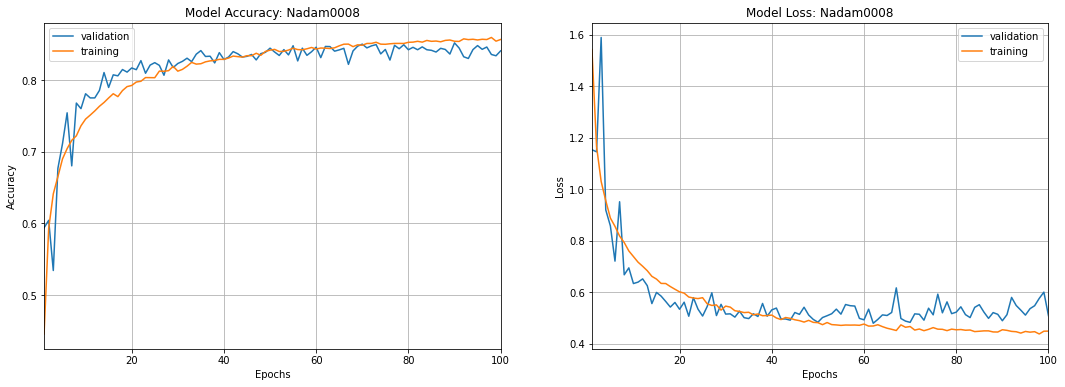

In [26]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam0008.h5")

numOfEpochs_Nadam0008 = len(history_Nadam0008.history['loss'])
print("Epochs: ", numOfEpochs_Nadam0008)

test_loss_Nadam0008, test_accuracy_Nadam0008 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam0008))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam0008))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam0008, numOfEpochs_Nadam0008, 
                     model_name)

## Experiment 10: NAdam (lr = 0.0009)

In [27]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.0009)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam0009"
model_name_format = "Nadam0009.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam0009 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam0009_sec = t1-t0
duration_Nadam0009 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam0009)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 8s 11ms/step - loss: 1.5398 - accuracy: 0.4503 - val_loss: 1.2349 - val_accuracy: 0.5800
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 1.1534 - accuracy: 0.5997 - val_loss: 1.1899 - val_accuracy: 0.6070
Epoch 3/100
704/704 [==============================] - 7s 11ms/step - loss: 1.0281 - accuracy: 0.6414 - val_loss: 1.0924 - val_accuracy: 0.6268
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 0.9546 - accuracy: 0.6677 - val_loss: 0.8638 - val_accuracy: 0.7018
Epoch 5/100
704/704 [==============================] - 7s 11ms/step - loss: 0.9016 - accuracy: 0.6858 - val_loss: 0.8514 - val_accuracy: 0.7138
Epoch 6/100
704/704 [==============================] - 7s 11ms/step - loss: 0.8689 - accuracy: 0.6978 - val_loss: 0.7386 - val_accuracy: 0.7422
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 0.8303 - accuracy: 0.7114 - val_loss: 1.1044 - val_accuracy:

Epochs:  100

Nadam1 Test Accuracy: 0.100
Nadam1 Test Loss: 7.947

Test Confusion Matrix:
[[   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]]


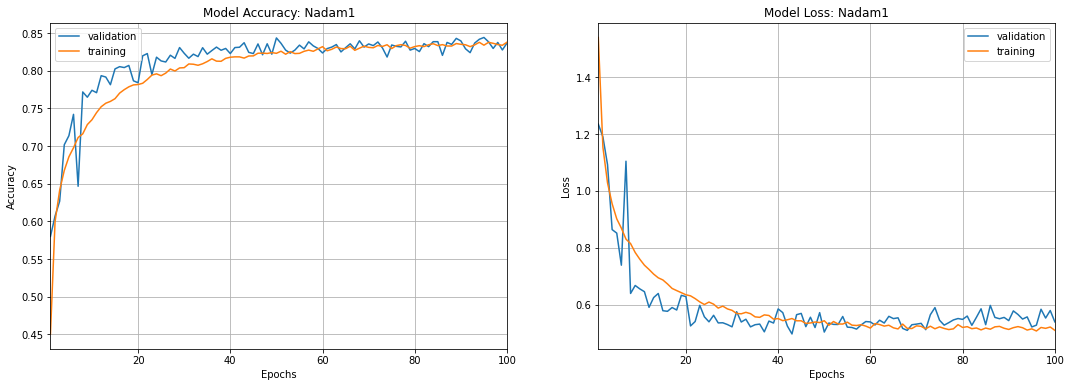

In [48]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam0009.h5")

numOfEpochs_Nadam0009 = len(history_Nadam0009.history['loss'])
print("Epochs: ", numOfEpochs_Nadam0009)

test_loss_Nadam0009, test_accuracy_Nadam0009 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam0009))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam0009))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam0009, numOfEpochs_Nadam0009, 
                     model_name)

## Experiment 11: NAdam (lr = 0.001)

In [29]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.001)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam001"
model_name_format = "Nadam001.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam001 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam001_sec = t1-t0
duration_Nadam001 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam001)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 7s 11ms/step - loss: 1.5405 - accuracy: 0.4528 - val_loss: 1.2088 - val_accuracy: 0.5844
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 1.1559 - accuracy: 0.5965 - val_loss: 1.3907 - val_accuracy: 0.5196
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 1.0347 - accuracy: 0.6358 - val_loss: 0.9793 - val_accuracy: 0.6646
Epoch 4/100
704/704 [==============================] - 8s 11ms/step - loss: 0.9700 - accuracy: 0.6615 - val_loss: 0.9439 - val_accuracy: 0.6770
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 0.9133 - accuracy: 0.6806 - val_loss: 0.9617 - val_accuracy: 0.6816
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 0.8875 - accuracy: 0.6929 - val_loss: 0.7122 - val_accuracy: 0.7554
Epoch 7/100
704/704 [==============================] - 7s 11ms/step - loss: 0.8515 - accuracy: 0.7054 - val_loss: 1.5370 - val_accuracy:

Epochs:  100

Nadam001 Test Accuracy: 0.100
Nadam001 Test Loss: 2.313

Test Confusion Matrix:
[[   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]]


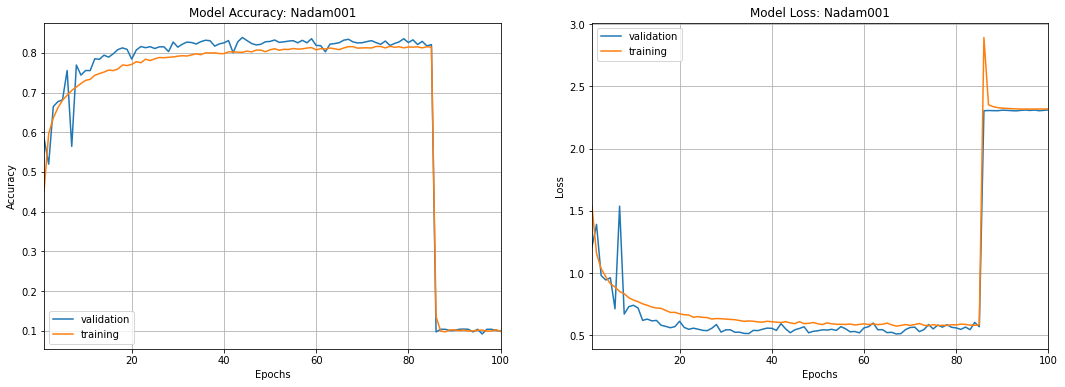

In [30]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam001.h5")

numOfEpochs_Nadam001 = len(history_Nadam001.history['loss'])
print("Epochs: ", numOfEpochs_Nadam001)

test_loss_Nadam001, test_accuracy_Nadam001 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam001))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam001))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam001, numOfEpochs_Nadam001, 
                     model_name)

## Experiment 12: NAdam (lr = 0.005)

In [31]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.005)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam005"
model_name_format = "Nadam005.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam005 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam005_sec = t1-t0
duration_Nadam005 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam005)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 8s 11ms/step - loss: 3.4698 - accuracy: 0.0993 - val_loss: 2.3342 - val_accuracy: 0.1038
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 2.3813 - accuracy: 0.0982 - val_loss: 2.4362 - val_accuracy: 0.1040
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 2.3531 - accuracy: 0.0987 - val_loss: 2.4758 - val_accuracy: 0.0920
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 2.3547 - accuracy: 0.0997 - val_loss: 2.4711 - val_accuracy: 0.0920
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 2.3570 - accuracy: 0.0994 - val_loss: 2.4095 - val_accuracy: 0.1010
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 2.3605 - accuracy: 0.0997 - val_loss: 2.3641 - val_accuracy: 0.1038
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 226.1948 - accuracy: 0.0983 - val_loss: 2.3390 - val_accurac

Epochs:  100

Nadam005 Test Accuracy: 0.100
Nadam005 Test Loss: 2.404

Test Confusion Matrix:
[[   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]]


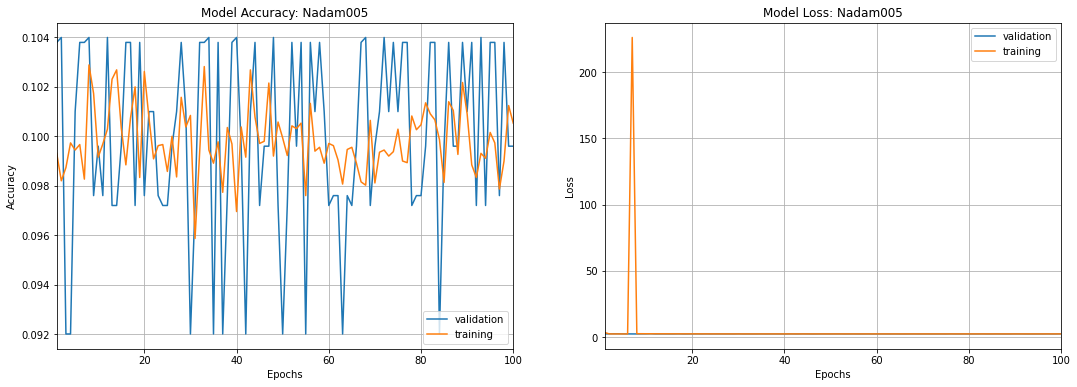

In [32]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam005.h5")

numOfEpochs_Nadam005 = len(history_Nadam005.history['loss'])
print("Epochs: ", numOfEpochs_Nadam005)

test_loss_Nadam005, test_accuracy_Nadam005 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam005))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam005))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam005, numOfEpochs_Nadam005, 
                     model_name)

## Experiment 13: NAdam (lr = 0.007)

In [33]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.007)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam007"
model_name_format = "Nadam007.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam007 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam007_sec = t1-t0
duration_Nadam007 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam007)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 7s 11ms/step - loss: 4.0267 - accuracy: 0.1016 - val_loss: 2.3227 - val_accuracy: 0.1010
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 2.3914 - accuracy: 0.0999 - val_loss: 2.4536 - val_accuracy: 0.1040
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 2.3601 - accuracy: 0.0973 - val_loss: 2.4917 - val_accuracy: 0.0920
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 6821.7217 - accuracy: 0.0989 - val_loss: 2.5017 - val_accuracy: 0.0996
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 2.6300 - accuracy: 0.1024 - val_loss: 2.4573 - val_accuracy: 0.0972
Epoch 6/100
704/704 [==============================] - 9s 13ms/step - loss: 2.6158 - accuracy: 0.1003 - val_loss: 2.3487 - val_accuracy: 0.0972
Epoch 7/100
704/704 [==============================] - 9s 12ms/step - loss: 16.1331 - accuracy: 0.1011 - val_loss: 2.3537 - val_accur

Epochs:  100

Nadam007 Test Accuracy: 0.100
Nadam007 Test Loss: 2.444

Test Confusion Matrix:
[[   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]]


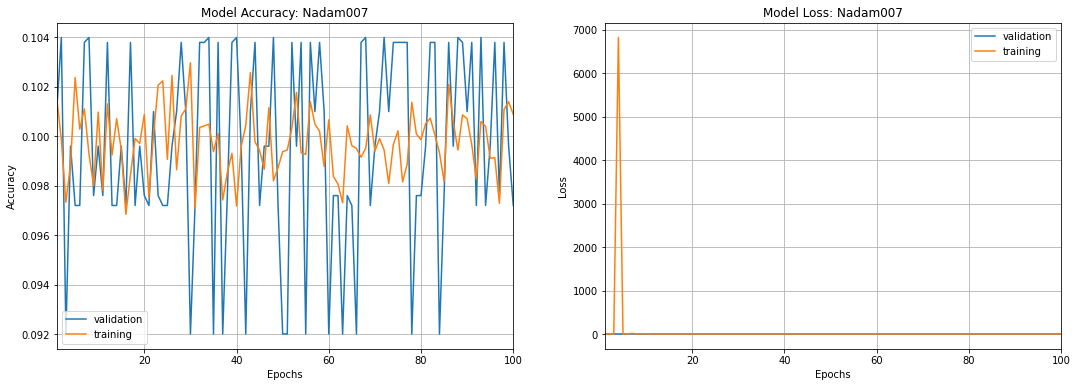

In [34]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam007.h5")

numOfEpochs_Nadam007 = len(history_Nadam007.history['loss'])
print("Epochs: ", numOfEpochs_Nadam007)

test_loss_Nadam007, test_accuracy_Nadam007 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam007))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam007))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam007, numOfEpochs_Nadam007, 
                     model_name)

## Experiment 14: NAdam (lr = 0.03)

In [35]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.03)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam03"
model_name_format = "Nadam03.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam03 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam03_sec = t1-t0
duration_Nadam03 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam03)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 8s 11ms/step - loss: 593.3704 - accuracy: 0.0985 - val_loss: 2.3058 - val_accuracy: 0.0976
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 3.0834 - accuracy: 0.0999 - val_loss: 2.3114 - val_accuracy: 0.0976
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 2.9566 - accuracy: 0.1011 - val_loss: 2.3179 - val_accuracy: 0.0972
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 2.8862 - accuracy: 0.0984 - val_loss: 2.3298 - val_accuracy: 0.0996
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 2.8337 - accuracy: 0.1016 - val_loss: 2.3215 - val_accuracy: 0.0972
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 2.7170 - accuracy: 0.0979 - val_loss: 2.3263 - val_accuracy: 0.1038
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 132328872.0000 - accuracy: 0.0993 - val_loss: 2.5859 - val

Epochs:  100

Nadam03 Test Accuracy: 0.100
Nadam03 Test Loss: 2.989

Test Confusion Matrix:
[[   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]]


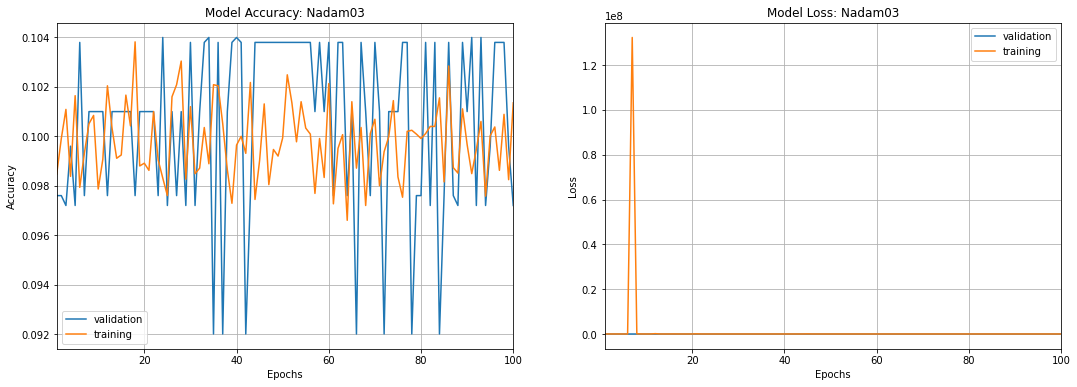

In [36]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam03.h5")

numOfEpochs_Nadam03 = len(history_Nadam03.history['loss'])
print("Epochs: ", numOfEpochs_Nadam03)

test_loss_Nadam03, test_accuracy_Nadam03 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam03))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam03))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam03, numOfEpochs_Nadam03, 
                     model_name)

## Experiment 15: NAdam (lr = 0.05)

In [37]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.05)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam05"
model_name_format = "Nadam05.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam05 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam05_sec = t1-t0
duration_Nadam05 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam05)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 8s 11ms/step - loss: 4205.0508 - accuracy: 0.0995 - val_loss: 2.3439 - val_accuracy: 0.1040
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 3.3766 - accuracy: 0.1024 - val_loss: 2.4080 - val_accuracy: 0.1040
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 3.3073 - accuracy: 0.1000 - val_loss: 2.3270 - val_accuracy: 0.1038
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 3.2354 - accuracy: 0.0992 - val_loss: 2.3553 - val_accuracy: 0.0996
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 3.1550 - accuracy: 0.1010 - val_loss: 2.3592 - val_accuracy: 0.0972
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 3.0975 - accuracy: 0.0984 - val_loss: 2.3626 - val_accuracy: 0.1038
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 3.0116 - accuracy: 0.1010 - val_loss: 2.3753 - val_accura

Epochs:  100

Nadam05 Test Accuracy: 0.100
Nadam05 Test Loss: 3.357

Test Confusion Matrix:
[[   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]]


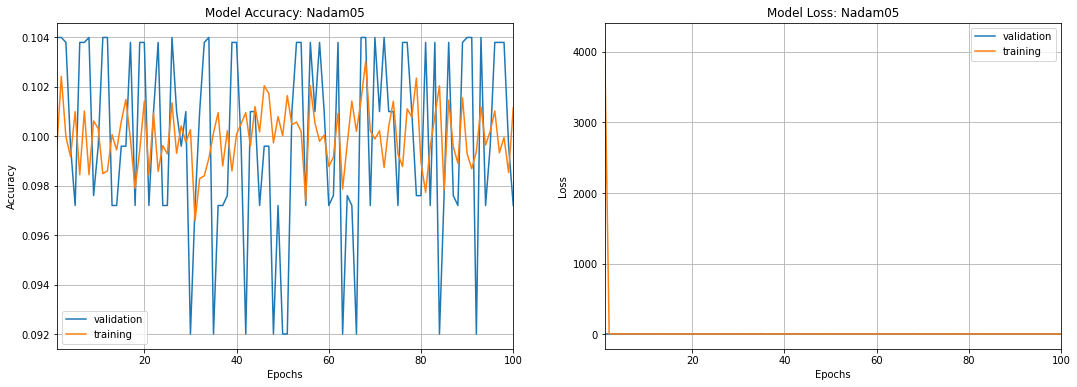

In [38]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam05.h5")

numOfEpochs_Nadam05 = len(history_Nadam05.history['loss'])
print("Epochs: ", numOfEpochs_Nadam05)

test_loss_Nadam05, test_accuracy_Nadam05 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam05))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam05))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam05, numOfEpochs_Nadam05, 
                     model_name)

## Experiment 16: NAdam (lr = 0.07)

In [39]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.07)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam07"
model_name_format = "Nadam07.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam07 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam07_sec = t1-t0
duration_Nadam07 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam07)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 7s 11ms/step - loss: 1062296.3750 - accuracy: 0.1011 - val_loss: 2.3228 - val_accuracy: 0.1038
Epoch 2/100
704/704 [==============================] - 7s 11ms/step - loss: 4.9533 - accuracy: 0.0993 - val_loss: 2.3158 - val_accuracy: 0.1038
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 4.6333 - accuracy: 0.1002 - val_loss: 2.3094 - val_accuracy: 0.1010
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 4.2383 - accuracy: 0.0988 - val_loss: 2.3375 - val_accuracy: 0.0996
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 4.2084 - accuracy: 0.1006 - val_loss: 2.3105 - val_accuracy: 0.1038
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 4.2176 - accuracy: 0.1007 - val_loss: 2.3213 - val_accuracy: 0.1038
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 54523432960.0000 - accuracy: 0.0993 - val_loss: 11.206

Epochs:  100

Nadam07 Test Accuracy: 0.100
Nadam07 Test Loss: 4.090

Test Confusion Matrix:
[[   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]]


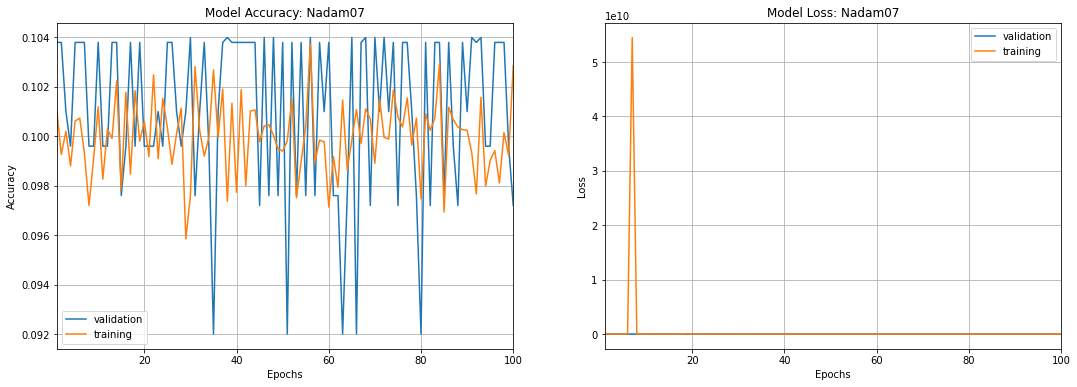

In [40]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam07.h5")

numOfEpochs_Nadam07 = len(history_Nadam07.history['loss'])
print("Epochs: ", numOfEpochs_Nadam07)

test_loss_Nadam07, test_accuracy_Nadam07 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam07))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam07))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam07, numOfEpochs_Nadam07, 
                     model_name)

## Experiment 17: NAdam (lr = 0.09)

In [41]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.09)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam09"
model_name_format = "Nadam09.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam09 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam09_sec = t1-t0
duration_Nadam09 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam09)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 8s 11ms/step - loss: 5349861.0000 - accuracy: 0.0994 - val_loss: 2.3498 - val_accuracy: 0.1038
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 14.7561 - accuracy: 0.1004 - val_loss: 2.4076 - val_accuracy: 0.1038
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 9.1846 - accuracy: 0.1022 - val_loss: 2.3302 - val_accuracy: 0.0920
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 10.8575 - accuracy: 0.0984 - val_loss: 2.4245 - val_accuracy: 0.0996
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 6.4182 - accuracy: 0.1000 - val_loss: 2.3606 - val_accuracy: 0.0996
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 5.9500 - accuracy: 0.0995 - val_loss: 2.3608 - val_accuracy: 0.0920
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 5.9978 - accuracy: 0.1005 - val_loss: 2.3746 - val_a

Epochs:  100

Nadam09 Test Accuracy: 0.100
Nadam09 Test Loss: 8.562

Test Confusion Matrix:
[[   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]
 [   0    0    0 1000    0    0    0    0    0    0]]


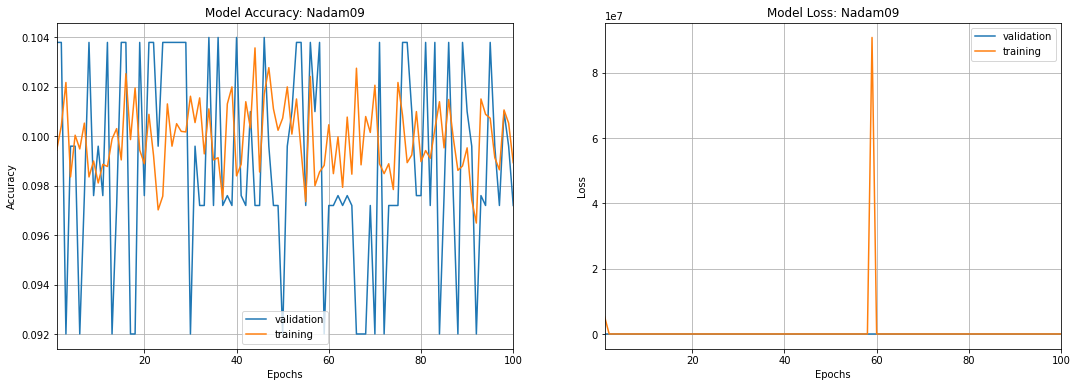

In [42]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam09.h5")

numOfEpochs_Nadam09 = len(history_Nadam09.history['loss'])
print("Epochs: ", numOfEpochs_Nadam09)

test_loss_Nadam09, test_accuracy_Nadam09 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam09))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam09))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam09, numOfEpochs_Nadam09, 
                     model_name)

## Experiment 18: NAdam (lr = 0.1)

In [43]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=0.1)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "Nadam1"
model_name_format = "Nadam1.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_Nadam1 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_Nadam1_sec = t1-t0
duration_Nadam1 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Nadam1)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 7s 10ms/step - loss: 2408363.7500 - accuracy: 0.0984 - val_loss: 2.3814 - val_accuracy: 0.1038
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 5.4544 - accuracy: 0.0976 - val_loss: 2.3713 - val_accuracy: 0.0972
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 5.2279 - accuracy: 0.1008 - val_loss: 2.4216 - val_accuracy: 0.1038
Epoch 4/100
704/704 [==============================] - 7s 10ms/step - loss: 6.2619 - accuracy: 0.0968 - val_loss: 2.4190 - val_accuracy: 0.1010
Epoch 5/100
704/704 [==============================] - 7s 10ms/step - loss: 5.2079 - accuracy: 0.0987 - val_loss: 2.4565 - val_accuracy: 0.1038
Epoch 6/100
704/704 [==============================] - 7s 10ms/step - loss: 5.6215 - accuracy: 0.1015 - val_loss: 2.4075 - val_accuracy: 0.1038
Epoch 7/100
704/704 [==============================] - 7s 10ms/step - loss: 5.2884 - accuracy: 0.0991 - val_loss: 2.4754 - val_acc

Epochs:  100

Nadam1 Test Accuracy: 0.100
Nadam1 Test Loss: 7.947

Test Confusion Matrix:
[[   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]
 [   0    0    0    0    0    0    0    0    0 1000]]


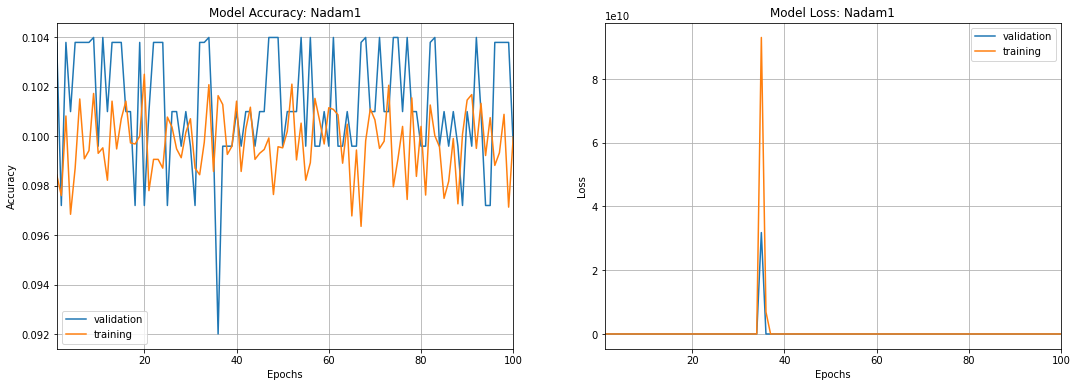

In [44]:
# Load the saved model for making predictions
#model = keras.models.load_model("Nadam1.h5")

numOfEpochs_Nadam1 = len(history_Nadam1.history['loss'])
print("Epochs: ", numOfEpochs_Nadam1)

test_loss_Nadam1, test_accuracy_Nadam1 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_Nadam1))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_Nadam1))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_Nadam1, numOfEpochs_Nadam1, 
                     model_name)

## Comparison of Validation Accuracy Over Epochs

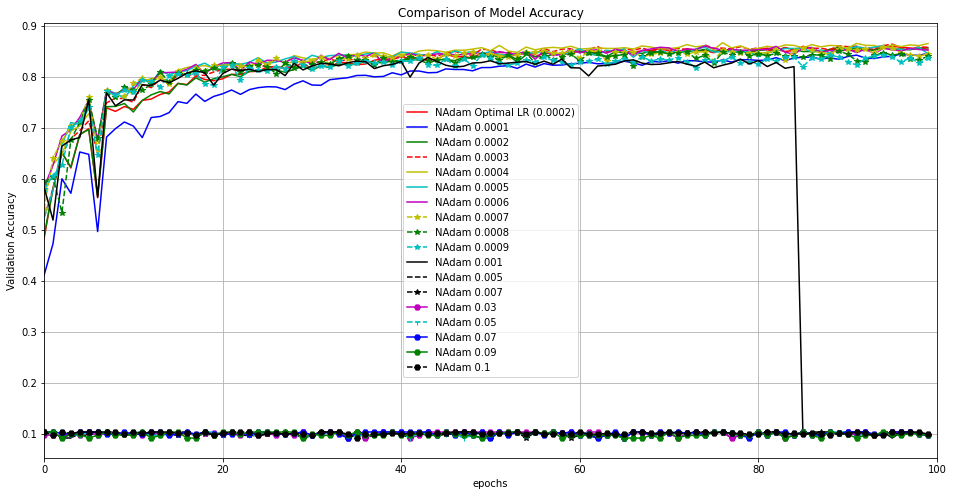

In [49]:
epochs = max(numOfEpochs_Nadam_opt, numOfEpochs_Nadam0001, numOfEpochs_Nadam0002, numOfEpochs_Nadam0003, 
             numOfEpochs_Nadam0004, numOfEpochs_Nadam0005,
             numOfEpochs_Nadam0006, numOfEpochs_Nadam0007, 
             numOfEpochs_Nadam0008, numOfEpochs_Nadam0009,
             numOfEpochs_Nadam001, numOfEpochs_Nadam005,
            numOfEpochs_Nadam007, numOfEpochs_Nadam03, numOfEpochs_Nadam05,
            numOfEpochs_Nadam07, numOfEpochs_Nadam09, numOfEpochs_Nadam1)

plt.figure(figsize=(16,8))
plt.plot(range(numOfEpochs_Nadam_opt),history_Nadam_opt.history['val_accuracy'],'r-',
         label='NAdam Optimal LR (0.0002)')
plt.plot(range(numOfEpochs_Nadam0001),history_Nadam0001.history['val_accuracy'],'b-',
         label='NAdam 0.0001')
plt.plot(range(numOfEpochs_Nadam0002),history_Nadam0002.history['val_accuracy'],'g-',
         label='NAdam 0.0002')
plt.plot(range(numOfEpochs_Nadam0003),history_Nadam0003.history['val_accuracy'],'r--',
         label='NAdam 0.0003')
plt.plot(range(numOfEpochs_Nadam0004),history_Nadam0004.history['val_accuracy'],'y-',
         label='NAdam 0.0004')
plt.plot(range(numOfEpochs_Nadam0005),history_Nadam0005.history['val_accuracy'],'c-',
         label='NAdam 0.0005')
plt.plot(range(numOfEpochs_Nadam0006),history_Nadam0006.history['val_accuracy'],'m-',
         label='NAdam 0.0006')
plt.plot(range(numOfEpochs_Nadam0007),history_Nadam0007.history['val_accuracy'],'y*--',
         label='NAdam 0.0007')
plt.plot(range(numOfEpochs_Nadam0008),history_Nadam0008.history['val_accuracy'],'g*--',
         label='NAdam 0.0008')
plt.plot(range(numOfEpochs_Nadam0009),history_Nadam0009.history['val_accuracy'],'c*--',
         label='NAdam 0.0009')
plt.plot(range(numOfEpochs_Nadam001),history_Nadam001.history['val_accuracy'],'k-',
         label='NAdam 0.001')
plt.plot(range(numOfEpochs_Nadam005),history_Nadam005.history['val_accuracy'],'k--',
         label='NAdam 0.005')
plt.plot(range(numOfEpochs_Nadam007),history_Nadam007.history['val_accuracy'],'k*--',
         label='NAdam 0.007')
plt.plot(range(numOfEpochs_Nadam03),history_Nadam03.history['val_accuracy'],'mH-',
         label='NAdam 0.03')
plt.plot(range(numOfEpochs_Nadam05),history_Nadam05.history['val_accuracy'],'c1--',
         label='NAdam 0.05')
plt.plot(range(numOfEpochs_Nadam07),history_Nadam07.history['val_accuracy'],'bH-',
         label='NAdam 0.07')
plt.plot(range(numOfEpochs_Nadam09),history_Nadam09.history['val_accuracy'],'gH-',
         label='NAdam 0.09')
plt.plot(range(numOfEpochs_Nadam1),history_Nadam1.history['val_accuracy'],'kH--',
         label='NAdam 0.1')


plt.legend(loc=0)
plt.xlabel('epochs')
plt.xlim([0,epochs])
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.title("Comparison of Model Accuracy")
plt.show()


## Comparison of Test Accuracy and Total Number of Epochs

In [50]:
data = [
    ["1: NAdam Optimal LR (0.0002)", numOfEpochs_Nadam_opt, duration_Nadam_opt, test_accuracy_Nadam_opt],
    ["2: NAdam 0.0001", numOfEpochs_Nadam0001, duration_Nadam0001, test_accuracy_Nadam0001],
    ["3: NAdam 0.0002", numOfEpochs_Nadam0002, duration_Nadam0002, test_accuracy_Nadam0002],
    ["4: NAdam 0.0003", numOfEpochs_Nadam0003, duration_Nadam0003, test_accuracy_Nadam0003],
    ["5: NAdam 0.0004", numOfEpochs_Nadam0004, duration_Nadam0004, test_accuracy_Nadam0004],
    ["6: NAdam 0.0005", numOfEpochs_Nadam0005, duration_Nadam0005, test_accuracy_Nadam0005],
    ["7: NAdam 0.0006", numOfEpochs_Nadam0006, duration_Nadam0006, test_accuracy_Nadam0006],
    ["8: NAdam 0.0007", numOfEpochs_Nadam0007, duration_Nadam0007, test_accuracy_Nadam0007],
    ["9: NAdam 0.0008", numOfEpochs_Nadam0008, duration_Nadam0008, test_accuracy_Nadam0008],
    ["10: NAdam 0.0009", numOfEpochs_Nadam0009, duration_Nadam0009, test_accuracy_Nadam0009],
    ["11: NAdam 0.001", numOfEpochs_Nadam001, duration_Nadam001, test_accuracy_Nadam001],
    ["12: NAdam 0.005", numOfEpochs_Nadam005, duration_Nadam005, test_accuracy_Nadam005],
    ["13: NAdam 0.007", numOfEpochs_Nadam007, duration_Nadam007, test_accuracy_Nadam007],
    ["14: NAdam 0.03", numOfEpochs_Nadam03, duration_Nadam03, test_accuracy_Nadam03],
    ["15: NAdam 0.05", numOfEpochs_Nadam05, duration_Nadam05, test_accuracy_Nadam05],
    ["16: NAdam 0.07", numOfEpochs_Nadam07, duration_Nadam07, test_accuracy_Nadam07],
    ["17: NAdam 0.09", numOfEpochs_Nadam09, duration_Nadam09, test_accuracy_Nadam09],
    ["18: NAdam 0.1", numOfEpochs_Nadam1, duration_Nadam1, test_accuracy_Nadam1]
    ]
pd.DataFrame(data, columns=["Experiments", "Epochs", "Training (Wall) Time", "Test Accuracy"])

,Experiments,Epochs,Training (Wall) Time,Test Accuracy
0,1: NAdam Optimal LR (0.0002),100,11 min 52 s,0.8451
1,2: NAdam 0.0001,100,11 min 52 s,0.8361
2,3: NAdam 0.0002,100,11 min 51 s,0.8449
3,4: NAdam 0.0003,100,11 min 52 s,0.8464
4,5: NAdam 0.0004,100,11 min 50 s,0.8467
5,6: NAdam 0.0005,100,11 min 50 s,0.8461
6,7: NAdam 0.0006,100,12 min 8 s,0.8478
7,8: NAdam 0.0007,100,11 min 55 s,0.8400
8,9: NAdam 0.0008,100,11 min 51 s,0.8366
9,10: NAdam 0.0009,100,12 min 18 s,0.1000


## Comparative Analysis

Below we compare the performance of the following two approaches. 

- Approach 1: Train the CNN **partially** for a few epochs by increasing LR within a range and use the LR that gives minimum loss as the optimal LR.
- Approach 2: Train the CNN **fully** for a large and fixed number of epochs (100 epochs) multiple times by varying the LR from a very small value to a large value. The optimal LR is then selected from the best performing model.



Our comparison is based on the results obtained from the following experiments. Experiment 1 implements approach 1 and the rest of the experiments implement approach 2.

- Experiment 1: NAdam (Optimal lr)
- Experiment 2: NAdam (lr = 0.0001)
- Experiment 3: NAdam (lr = 0.0002)
- Experiment 4: NAdam (lr = 0.0003)
- Experiment 5: NAdam (lr = 0.0004)
- Experiment 6: NAdam (lr = 0.0005)
- Experiment 7: NAdam (lr = 0.0006)
- Experiment 8: NAdam (lr = 0.0007)
- Experiment 9: NAdam (lr = 0.0008)
- Experiment 10: NAdam (lr = 0.0009)
- Experiment 11: NAdam (lr = 0.001)
- Experiment 12: NAdam (lr = 0.005)
- Experiment 13: NAdam (lr = 0.007)
- Experiment 14: NAdam (lr = 0.03)
- Experiment 15: NAdam (lr = 0.05)
- Experiment 16: NAdam (lr = 0.07)
- Experiment 17: NAdam (lr = 0.09)
- Experiment 18: NAdam (lr = 0.1)


Following are the optimal LR obtained from two aproaches:
- Approach 1: 0.0002 (test accuracy = 0.8451)
- Approach 1: 0.0006 (test accuracy = 0.8478)

We see that the test accuracy obtained by using optimal LR from approach 1 is almost equal to the test accuracy that we achieved using the optimal LR from approach 2. However, approach 2 is expensive, and prohibitively time-consuming for larger dataset.

    Thus, approach 1 could be used as a feasible technique to find optimal LR for NAdam (or other fast optimizers).


An interesting observation from these experiments is that increasing the LR doesn't expedite the convergence speed. All LRs that achieve large test accuracy (>0.70) require almost the same number of epochs (and training time) to converge.

Thus, unlike the vanilla SGD, we cannot increase the learning speed by using large LR in fast optimizers. Previously we have seen that by using 1cycle learning rate schedule we not only achieved effectiveness (high test accuracy) but also efficiency (faster convergence). This notebook should help to determine the optimal LR for fast optimizers when there is a need to use adaptive learning rate for SGD.
